<a href="https://colab.research.google.com/github/kirupapremakannan/Sentimental-Analysis_HackmastersUnited/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-dataset-of-50k-movie-reviews:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F134715%2F320111%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240430%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240430T094204Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4078757e086060ae17a73dc7d297746d89b94fbd775d4b1cde7b5a138e3dfa0b1160cb56f9fccc170f265d970c00bb9b9eedf6daccd0bd1e39a0d81006c9cbe0eef89393d0f8671aa90f0f5d469baecf142dc2f9a3ca59c6726c710583b46afc5e760450ece0069423c8aafc5f3e68f3633f264b9d0aedef1443e53831113ad60bb1d7ee3825cbfd6713d5cc0b295f35500c1a1d33e1f61b1e0afdb31fbc851d41c4fe49e04753936a515821dd84e6e446640070385d565195b1c6a273131727588384670562a202bef4e526f444a4e488eeba548319de9bbc3db492285a8162fc7f7ccec5f98dcf7d181c760c0ca12900568e3f7b2dfaaa43683d982f75db97'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 26962657 bytes downloaded
Downloaded and uncompressed: imdb-dataset-of-50k-movie-reviews
Data source import complete.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
reviews = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
reviews['sentiment'] = np.where(reviews['sentiment'] == 'positive', 1, 0)


In [5]:
sentences = reviews['review'].to_numpy()
labels = reviews['sentiment'].to_numpy()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25)
print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (37500,)
Training Data Output Shape:  (37500,)
Testing Data Input Shape:  (12500,)
Testing Data Output Shape:  (12500,)


In [7]:
vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)


In [8]:
tokenizer.fit_on_texts(X_train)
print("Number of Documents: ", tokenizer.document_count)
print("Number of Words: ", tokenizer.num_words)

Number of Documents:  37500
Number of Words:  10000


In [9]:
tokenizer.word_counts

OrderedDict([('i', 116610),
             ("can't", 5325),
             ('believe', 3738),
             ('that', 102800),
             ('they', 31565),
             ('took', 1680),
             ('this', 113234),
             ('off', 9024),
             ('the', 499202),
             ('air', 1046),
             ('especially', 3792),
             ('when', 21056),
             ('only', 17377),
             ('had', 16414),
             ('a', 241926),
             ('few', 6003),
             ('more', 21065),
             ('episodes', 1358),
             ('left', 3125),
             ('my', 18589),
             ('daughter', 1618),
             ('sister', 1127),
             ('and', 242843),
             ('of', 216595),
             ('friends', 2669),
             ('loved', 2202),
             ('watching', 6851),
             ('show', 9413),
             ('we', 14501),
             ('were', 15855),
             ('so', 30685),
             ('upset', 228),
             ('stopped', 333),
          

In [10]:

tokenizer.word_docs

defaultdict(int,
            {'promote': 87,
             'want': 4569,
             'especially': 3389,
             'when': 13471,
             'because': 9309,
             'i': 28972,
             'upset': 223,
             'mail': 127,
             'beginning': 1880,
             'show': 4997,
             'who': 16470,
             'more': 13437,
             'right': 4119,
             'tv': 3205,
             'loved': 1923,
             'sister': 887,
             'year': 2695,
             'and': 36199,
             'have': 21332,
             'free': 945,
             'not': 22279,
             'programs': 85,
             'end': 6672,
             'in': 32962,
             'use': 2364,
             'are': 20734,
             'as': 23953,
             'tool': 86,
             'people': 9045,
             'papers': 60,
             'viewers': 1033,
             'ratings': 227,
             'system': 438,
             'about': 15532,
             'could': 8638,
             'yo

In [11]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_sequences[0]

[11,
 185,
 262,
 13,
 34,
 549,
 12,
 123,
 2,
 871,
 258,
 52,
 34,
 62,
 68,
 4,
 171,
 51,
 680,
 315,
 58,
 562,
 808,
 3,
 4,
 171,
 5,
 58,
 356,
 432,
 148,
 12,
 120,
 74,
 71,
 35,
 3046,
 52,
 34,
 2274,
 760,
 12,
 84,
 5,
 35,
 429,
 2674,
 10,
 7,
 22,
 1231,
 6,
 2,
 86,
 37,
 71,
 148,
 12,
 120,
 236,
 2,
 460,
 74,
 68,
 4,
 206,
 6,
 63,
 2,
 129,
 11,
 637,
 34,
 60,
 190,
 33,
 439,
 2032,
 38,
 30,
 86,
 17,
 4,
 337,
 211,
 4,
 304,
 8326,
 1510,
 34,
 98,
 2168,
 42,
 7578,
 9,
 2,
 4290,
 3,
 74,
 15,
 804,
 98,
 195,
 33,
 439,
 2032,
 21,
 30,
 6062,
 13,
 74,
 104,
 39,
 26,
 558,
 43,
 12,
 98,
 82,
 346,
 6104,
 4,
 168,
 120,
 86,
 60,
 63,
 10,
 3,
 580,
 49,
 10,
 7,
 22,
 62,
 98,
 23,
 63,
 49,
 2,
 804,
 24,
 148,
 23,
 98,
 82,
 360,
 12,
 15,
 4,
 6213,
 16,
 877,
 9643,
 16,
 238,
 3,
 1827,
 4137,
 74,
 180,
 6,
 63,
 2,
 77,
 680,
 736,
 10,
 141]

In [12]:
sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')


In [13]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')


In [14]:
embedding_dim = 16
lstm_out = 32
model = Sequential()

In [15]:
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))

In [16]:
model.add(Bidirectional(LSTM(lstm_out)))

In [17]:
model.add(Dense(10, activation='relu'))

In [18]:
model.add(Dense(1,activation='sigmoid'))

In [19]:
model.compile(loss='binary_crossentropy',optimizer ='adam',metrics = ['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173205 (676.58 KB)
Trainable params: 173205 (676.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

In [22]:
history = model.fit(train_padded,y_train,epochs = 10, validation_data =(test_padded,y_test),callbacks=callbacks)

Epoch 1/10
1172/1172 [==============================] - 92s 74ms/step - loss: 0.4668 - accuracy: 0.7796 - val_loss: 0.3855 - val_accuracy: 0.8372
Epoch 2/10
1172/1172 [==============================] - 41s 35ms/step - loss: 0.3028 - accuracy: 0.8811 - val_loss: 0.3372 - val_accuracy: 0.8562
Epoch 3/10
1172/1172 [==============================] - 38s 33ms/step - loss: 0.2423 - accuracy: 0.9064 - val_loss: 0.3126 - val_accuracy: 0.8767
Epoch 4/10
1172/1172 [==============================] - 28s 24ms/step - loss: 0.1991 - accuracy: 0.9261 - val_loss: 0.3380 - val_accuracy: 0.8686
Epoch 5/10
1172/1172 [==============================] - 27s 23ms/step - loss: 0.1619 - accuracy: 0.9411 - val_loss: 0.3535 - val_accuracy: 0.8647


       loss  accuracy  val_loss  val_accuracy
0  0.466827  0.779600  0.385532       0.83720
1  0.302790  0.881093  0.337230       0.85616
2  0.242257  0.906427  0.312551       0.87672
3  0.199091  0.926133  0.337980       0.86864
4  0.161882  0.941120  0.353489       0.86472


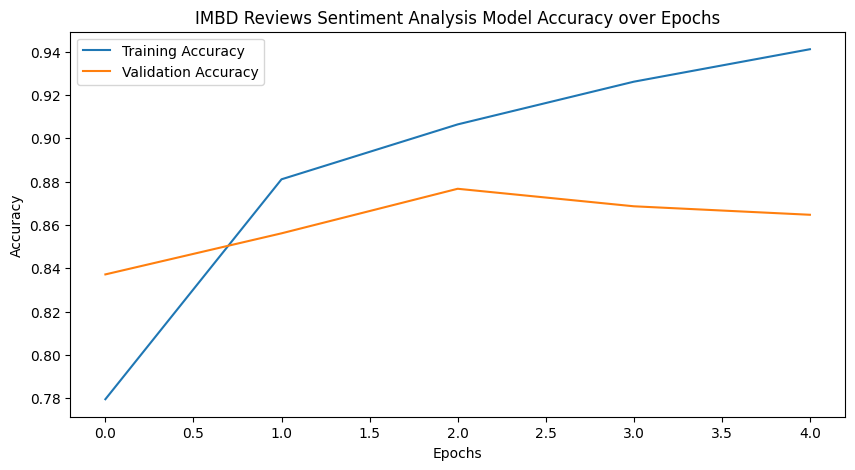

In [24]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('IMBD Reviews Sentiment Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [27]:
#has an accuracy of 86.9